# Load the packages


In [1]:
%reset
import numpy as np
import pickle as pk
import matplotlib
import matplotlib.pyplot as pl
from astropy import units
from astropy import constants
from astropy.io import fits
import sys, os
import dill
import os.path
import scipy as sp
import scipy.interpolate as interpolate

os.environ['COSMOSIS_SRC_DIR'] = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/'
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/cosmosis_code/')


Color = ['k', '#000075', '#a9a9a9','#9A6324', '#808000','#aaffc3', '#fffac8'  ,'#800000', '#ffd8b1',]


font = {'size'   : 18}
matplotlib.rc('font', **font)
pl.rc('text', usetex=True)
pl.rc('font', family='serif')



Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# Load the parent file with all the data saved


In [2]:
fdir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/'

fnames = [
    'DV_obj_temp_kk_gty_acty3_beamed_bf_kk_gty_wGcov_yytotnew_1_12500.pk',
]

DV = dill.load(open(fdir + fnames[0],'rb'))  



# Get the total auto-power spectrum of ACT D56 Compton-$y$ 


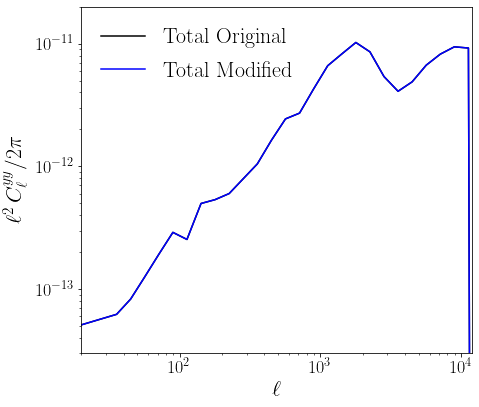

In [3]:
l_array_survey = DV.Cl_result_dict['l_array_survey']
Cl_yy_tot_orig = DV.Cl_result_dict['yy']['bin_0_0']['tot_plus_noise_ellsurvey']
lstar = 1e4
# Cl_yy_tot = Cl_yy_tot_orig * (np.exp(-1.*(l_array_survey**2)/(lstar ** 2)))
Cl_yy_tot = Cl_yy_tot_orig 


fig, ax = pl.subplots(1,1, figsize = (7,6))
ax.errorbar(l_array_survey,(1./(2.*np.pi))*(l_array_survey**2)*Cl_yy_tot_orig,ls='-',marker='',color='k',alpha=1.0,label='Total Original')  
ax.errorbar(l_array_survey,(1./(2.*np.pi))*(l_array_survey**2)*Cl_yy_tot,ls='-',marker='',color='b',alpha=1.0,label='Total Modified')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$', size = 22)
ax.set_ylabel(r'$\ell^2 \, C^{yy}_{\ell}/2\pi$', size = 22)
ax.set_ylim(3e-14,2e-11)
ax.set_xlim(20.0,12000)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.legend(fontsize = 22, frameon = False)
pl.tight_layout()







# Get the auto-power spectra of shearxshear ($\kappa \kappa$) and compare that to the shape noise. Shows that it is shape noise dominated in small scales. This total power spectra correctly matches the JK covariances of $\xi_{+}$ and $\xi_{-}$ saying that shape noise should be correct.


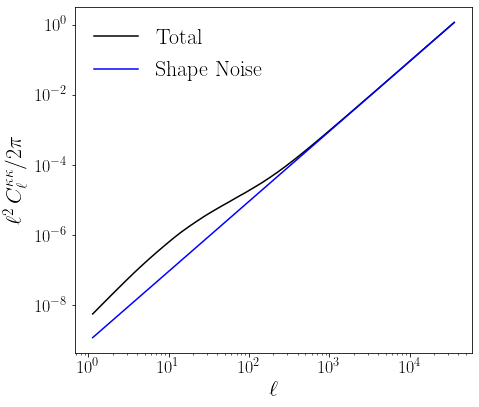

In [4]:
l_array_survey = DV.Cl_result_dict['l_array_survey']
Cl_kk_tot_orig = DV.Cl_result_dict['kk']['bin_4_4']['tot_plus_noise_ellsurvey']
shape_noise = Cl_kk_tot_orig - DV.Cl_result_dict['kk']['bin_4_4']['tot_ellsurvey']

fac_mod = 0.5
shape_noise_new = shape_noise*fac_mod
Cl_kk_tot = DV.Cl_result_dict['kk']['bin_4_4']['tot_ellsurvey'] + shape_noise_new

fig, ax = pl.subplots(1,1, figsize = (7,6))
ax.errorbar(l_array_survey,(1./(2.*np.pi))*(l_array_survey**2)*Cl_kk_tot,ls='-',marker='',color='k',alpha=1.0, label='Total')
ax.errorbar(l_array_survey,(1./(2.*np.pi))*(l_array_survey**2)*shape_noise_new,ls='-',marker='',color='b',alpha=1.0,label='Shape Noise')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\ell$', size = 22)
ax.set_ylabel(r'$\ell^2 \, C^{\kappa \kappa}_{\ell}/2\pi$', size = 22)
# ax.set_ylim(3e-14,2e-11)
# ax.set_xlim(20.0,12000)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.legend(fontsize = 22, frameon = False)
pl.tight_layout()








# Do a very simple and approximate Gaussian Covaraince estimation, basically Cov $ \sim $ $C^{\kappa \kappa} C^{yy}$


In [6]:
# fsky is estimated after taking into account the ACT and DES masks
fsky = 0.00955
l_array_survey = DV.Cl_result_dict['l_array_survey']
dl_array_survey = DV.Cl_result_dict['dl_array_survey']
covG = np.diag((1./(fsky * (2. * l_array_survey + 1.) * (dl_array_survey))) * (Cl_kk_tot * Cl_yy_tot))


# For a simple bin-averaged integrals we convert above calculated fourier covariance to real-space covariance. For that we need to interpolate this to a very fine grid. Do that interpolation (taking care of the spacing between the $\ell$ array elements.


In [7]:
cov_G_diag_interp = interpolate.interp1d(np.log(l_array_survey),
                                         np.log(dl_array_survey * np.diag(covG)),
                                         fill_value=-100.0, bounds_error=False)

l_array_full_all = np.logspace(np.log10(np.min(l_array_survey)), np.log10(np.max(l_array_survey)),
                               500000)
dl_array_full = l_array_full_all[1:] - l_array_full_all[:-1]
l_array_full = l_array_full_all[1:]

cov_G_diag_lfull = (np.exp(cov_G_diag_interp(np.log(l_array_full))))




# Define that simple function to do that calculation and do the esitmation


In [8]:
def get_covdiag_simple(theta_min, theta_max, ntheta, l_array, cov_diag):
#     Setup the theta array
    theta_array_all = np.logspace(np.log10(theta_min), np.log10(theta_max), ntheta)
    dtheta_array = (theta_array_all[1:] - theta_array_all[:-1]) / 2.
    theta_array = (theta_array_all[1:] + theta_array_all[:-1]) / 2.
    theta_plus_array = theta_array + dtheta_array / 2.
    theta_minus_array = theta_array - dtheta_array / 2.
    ntheta = len(theta_array)
    nl = len(l_array)

    theta_array_rad = theta_array * (np.pi / 180.) * (1. / 60.)
    dtheta_array_rad = dtheta_array * (np.pi / 180.) * (1. / 60.)
    thetaplus_array_rad = theta_plus_array * (np.pi / 180.) * (1. / 60.)
    thetaminus_array_rad = theta_minus_array * (np.pi / 180.) * (1. / 60.)

#     Set up the l_array and the argument of the functions
    l_mat = np.tile(l_array.reshape(1, nl), (ntheta, 1))
    theta_mat = np.tile(theta_array_rad.reshape(ntheta, 1), (1, nl))
    dtheta_mat = np.tile(dtheta_array_rad.reshape(ntheta, 1), (1, nl))
    thetaplus_mat = np.tile(thetaplus_array_rad.reshape(ntheta, 1), (1, nl))
    thetaminus_mat = np.tile(thetaminus_array_rad.reshape(ntheta, 1), (1, nl))
    l_thetaplus = l_mat * thetaplus_mat
    l_thetaminus = l_mat * thetaminus_mat

#     Setup the binning martrices
    J2_ltheta_binned_coeff = (1. / ( (l_mat**2) * theta_mat * dtheta_mat))
    term1 = -2. * (sp.special.jv(0, l_thetaplus) - sp.special.jv(0, l_thetaminus))
    term2 = -1. * l_mat * (thetaplus_mat * sp.special.jv(1, l_thetaplus) - thetaminus_mat * sp.special.jv(1, l_thetaminus))
    J2_ltheta_binned = J2_ltheta_binned_coeff * (term1 + term2)

    J2_ltheta_binned_mat1 = np.tile(J2_ltheta_binned.reshape(ntheta, 1, nl), (1, ntheta, 1))
    J2_ltheta_binned_mat2 = np.tile(J2_ltheta_binned.reshape(1, ntheta, nl), (ntheta, 1, 1))

    cov_diag_mat = np.tile(cov_diag.reshape(1, 1, nl), (ntheta, ntheta, 1))
    l_mat = np.tile(l_array.reshape(1, 1, nl), (ntheta, ntheta, 1))

    integrand = (l_mat ** 2) * (J2_ltheta_binned_mat1 * J2_ltheta_binned_mat2) * cov_diag_mat
    cov_simp = (1. / ((2 * np.pi) ** 2)) * sp.integrate.simps(integrand, l_array)

    return theta_array_rad, cov_simp


# Calculate the covariance
theta_rad, cov_gty_simp = get_covdiag_simple(2.5, 250, 21, l_array_full, cov_G_diag_lfull)
theta_amin = theta_rad * (180./np.pi) * 60.





# Now load the simulation results and show the measured correlations using various realizations


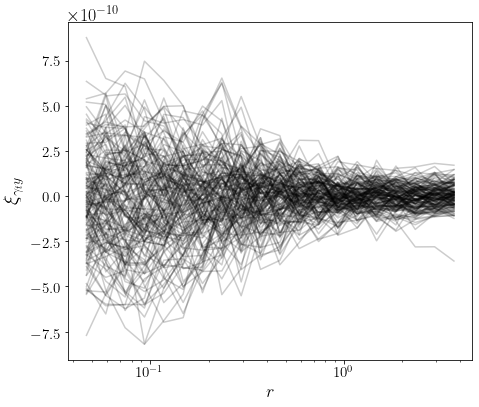

In [9]:
import os.path
import dill
sdir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/simsgty/'
frange = np.arange(400)
fig, ax = pl.subplots(1,1, figsize = (7,6))
gty_all = []
for ji in range(len(frange)):
    fname = sdir + 'gty_obj_sim_' + str(ji) + '_bin4y.pkl'
    if os.path.isfile(fname):
        fgty = dill.load(open(fname,'rb'))
        gty = fgty.xi
        rgty = np.exp(fgty.logr)
        ax.errorbar(rgty,gty,ls='-',marker='',color='k',alpha=0.2)
        
        if len(gty_all) == 0:
            gty_all = gty
        else:
            gty_all = np.vstack((gty_all,gty))

ax.set_xscale('log')
ax.set_xlabel(r'$r$', size = 18)
ax.set_ylabel(r'$\xi_{\gamma_t y}$', size = 20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
# ax.legend(fontsize = 18, frameon = False)
pl.tight_layout()




# Estimate the covariance from the above measurements


In [10]:
nsim, nrad = gty_all.shape
gty_mean = np.mean(gty_all,axis=0)
gty_mean_rp = np.tile(gty_mean.reshape(1,nrad),(nsim,1))

gty_diff = gty_all - gty_mean_rp
cov_ij = (1./(nsim - 1.)) * np.dot(gty_diff.T, gty_diff)
sig_sim = np.sqrt(np.diag(cov_ij))



# Now plot all the Covariance estimates and compare them. Blue curve is the 'Simple Theory' estimate as described above. Red curve is full theory bin-averaged estimate using proper fftlog technique. Green squares are the Jackknife estimate from 200 patches in data and Black diamonds are the simulation estimate as described above.


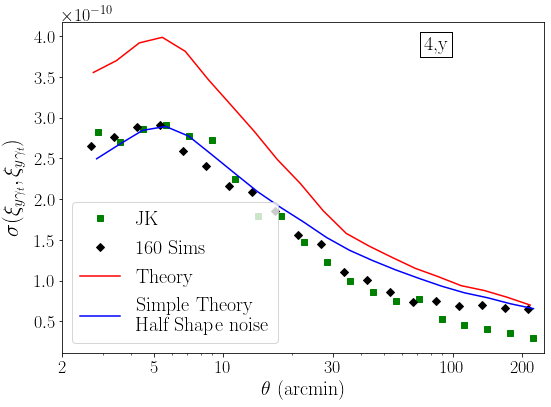

In [11]:
df = fits.open('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/DES_ACT.fits')
fdir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/'
fnames = [
    'DV_obj_temp_kk_gty_acty3_beamed_bf_kk_gty_wGcov_yytotnew_1_12500.pk',
]
colors = ['r','b','k']
labels = [
    r'Theory',
]

nbins = 4
bins1 = np.array([1,2,3,4])
bins2 = np.array([1,2,3,4])

fig, ax = pl.subplots(1,1, figsize = (8,6),sharex=True,sharey='row')
jc = 0
texts_kk = []
for j1 in range(len(bins1)):
    texts_kk.append(str(bins1[j1]) + ',' + str(bins2[j1]))
texts_ky = [r'1,y',r'2,y',r'3,y',r'4,y']

for j2 in range(4):
    for jfn in range(len(fnames)):
        DV = dill.load(open(fdir + fnames[jfn],'rb'))  
        theta_arr = DV.fftcovtot_dict['gty_gty']['theta']

        bin1y = df['compton_shear'].data['BIN1']
        bin2y = df['compton_shear'].data['BIN2']
        ind_sely = np.where((bin1y == bins1[j2]) & (bin2y == bins2[j2]))[0]

        cov_kk_binj2 = DV.fftcovtot_dict['gty_gty']['bin_' + str(bins1[j2]) + '_' + str(0) + '_' + str(bins2[j2]) + '_' + str(0)]  
        sig_kk_binj2 = np.sqrt(np.diag(cov_kk_binj2))
        ind_inth = np.where((theta_arr > 2.5) &  (theta_arr < 250.))[0]
        
        if jfn == 0:
            sig_th_interp = interpolate.interp1d(theta_arr, sig_kk_binj2,fill_value='extrapolate')
            yk_th_g = df['compton_shear'].data['ANG'][ind_sely]
            yk_err = np.sqrt(np.diag(df['COVMAT'].data[400:,400:][ind_sely,:][:,ind_sely]))

        if j2 == 3:
            ax.plot(yk_th_g, yk_err, ls='',marker='s',color='green',label='JK')
            ax.plot(rgty*(180./np.pi), sig_sim, ls='',marker='D',color='k',label= str(nsim) + ' Sims')
            ax.plot(theta_arr[ind_inth], sig_kk_binj2[ind_inth], ls='-',color=colors[jfn],label=labels[jfn])  
            ax.plot(theta_amin, np.sqrt(np.diag(cov_gty_simp)), ls='-',color='b',label='Simple Theory' + '\n' + 'Half Shape noise' )  

        ax.set_xscale('log')
#         ax.set_yscale('log')
        ax.set_xlabel(r'$\theta$ (arcmin)', size = 20)
        ticks  = np.array([2,5,10,30,100,200])
        labels_bottom = ticks
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels_bottom,  fontsize=18)

        ax.tick_params(axis='both', which='minor', labelsize=18)    
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.set_xlim((2,250))

        ax.text( 0.75, 0.96,'4,y', verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, fontsize=20, bbox=dict(facecolor='white', edgecolor='black'))    
        jc += 1

ax.set_ylabel(r'$\sigma(\xi_{y\gamma_t},\xi_{y\gamma_t})$', size = 22)
ax.legend(fontsize=20,loc='lower left')
pl.tight_layout()




In [47]:
binv = 2
l_array_survey = DV.Cl_result_dict['l_array_survey']
Cl_kk_tot_orig = DV.Cl_result_dict['kk']['bin_' + str(binv) + '_' + str(binv)]['tot_plus_noise_ellsurvey']
shape_noise = Cl_kk_tot_orig - DV.Cl_result_dict['kk']['bin_' + str(binv) + '_' + str(binv)]['tot_ellsurvey']

fac_mod = 0.5
shape_noise_new = shape_noise*fac_mod
Cl_kk_tot = DV.Cl_result_dict['kk']['bin_' + str(binv) + '_' + str(binv)]['tot_ellsurvey'] + shape_noise_new



In [48]:
# fsky is estimated after taking into account the ACT and DES masks
fsky = 0.1014
l_array_survey = DV.Cl_result_dict['l_array_survey']
dl_array_survey = DV.Cl_result_dict['dl_array_survey']
covG = np.diag((1./(fsky * (2. * l_array_survey + 1.) * (dl_array_survey))) * (2.*(Cl_kk_tot ** 2) + 2.*(shape_noise_new**2)))



In [49]:
cov_G_diag_interp = interpolate.interp1d(np.log(l_array_survey),
                                         np.log(dl_array_survey * np.diag(covG)),
                                         fill_value=-100.0, bounds_error=False)

l_array_full_all = np.logspace(np.log10(np.min(l_array_survey)), np.log10(np.max(l_array_survey)),
                               100000)
dl_array_full = l_array_full_all[1:] - l_array_full_all[:-1]
l_array_full = l_array_full_all[1:]

cov_G_diag_lfull = (np.exp(cov_G_diag_interp(np.log(l_array_full))))





In [50]:
def get_covdiag_simp00(theta_min, theta_max, ntheta, l_array, cov_diag):
        theta_array_all = np.logspace(np.log10(theta_min), np.log10(theta_max), ntheta)
        dtheta_array = (theta_array_all[1:] - theta_array_all[:-1]) / 2.
        theta_array = (theta_array_all[1:] + theta_array_all[:-1]) / 2.
        theta_plus_array = theta_array + dtheta_array / 2.
        theta_minus_array = theta_array - dtheta_array / 2.
        ntheta = len(theta_array)
        nl = len(l_array)

        theta_array_rad = theta_array * (np.pi / 180.) * (1. / 60.)
        dtheta_array_rad = dtheta_array * (np.pi / 180.) * (1. / 60.)
        thetaplus_array_rad = theta_plus_array * (np.pi / 180.) * (1. / 60.)
        thetaminus_array_rad = theta_minus_array * (np.pi / 180.) * (1. / 60.)

        l_mat = np.tile(l_array.reshape(1, nl), (ntheta, 1))
        theta_mat = np.tile(theta_array_rad.reshape(ntheta, 1), (1, nl))
        dtheta_mat = np.tile(dtheta_array_rad.reshape(ntheta, 1), (1, nl))
        thetaplus_mat = np.tile(thetaplus_array_rad.reshape(ntheta, 1), (1, nl))
        thetaminus_mat = np.tile(thetaminus_array_rad.reshape(ntheta, 1), (1, nl))
        l_thetaplus = l_mat * thetaplus_mat
        l_thetaminus = l_mat * thetaminus_mat
        J1_ltheta_plus = sp.special.jv(1, l_thetaplus)
        J1_ltheta_minus = sp.special.jv(1, l_thetaminus)
        J0_ltheta_binned = (1. / (l_mat * theta_mat * dtheta_mat)) * (
                thetaplus_mat * J1_ltheta_plus - thetaminus_mat * J1_ltheta_minus)

        J0_ltheta_binned_mat1 = np.tile(J0_ltheta_binned.reshape(ntheta, 1, nl), (1, ntheta, 1))
        J0_ltheta_binned_mat2 = np.tile(J0_ltheta_binned.reshape(1, ntheta, nl), (ntheta, 1, 1))

        cov_diag_mat = np.tile(cov_diag.reshape(1, 1, nl), (ntheta, ntheta, 1))
        l_mat = np.tile(l_array.reshape(1, 1, nl), (ntheta, ntheta, 1))

        integrand = (l_mat ** 2) * (J0_ltheta_binned_mat1 * J0_ltheta_binned_mat2) * cov_diag_mat
        cov_wtheta = (1. / ((2 * np.pi) ** 2)) * sp.integrate.simps(integrand, l_array)

        return theta_array_rad, cov_wtheta
    
    


# Calculate the covariance
theta_rad, cov_gty_simp = get_covdiag_simp00(2.5, 250, 21, l_array_full, cov_G_diag_lfull)
theta_amin = theta_rad * (180./np.pi) * 60.






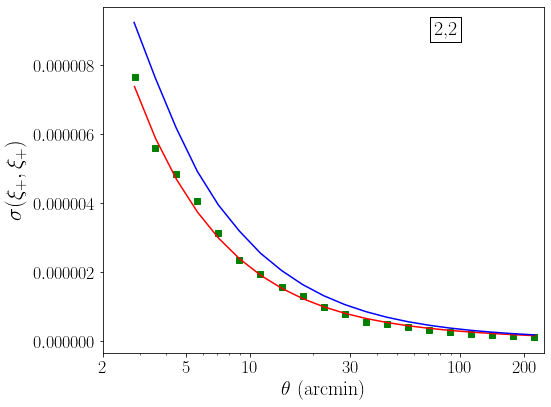

In [51]:
df = fits.open('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/DES_ACT.fits')
fdir = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/'
fnames = [
    'DV_obj_temp_kk_gty_acty3_beamed_bf_kk_gty_wGcov_yytotnew_1_12500.pk',
]

from astropy.io import fits
desy1 = fits.open('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/v0.40_fiducial.fits')



colors = ['r','b','k']
labels = [
    r'Theory',
]

nbins = 4
bins1 = np.array([1,2,3,4])
bins2 = np.array([1,2,3,4])

fig, ax = pl.subplots(1,1, figsize = (8,6),sharex=True,sharey='row')
jc = 0
texts_kk = []
for j1 in range(len(bins1)):
    texts_kk.append(str(bins1[j1]) + ',' + str(bins2[j1]))
texts_ky = [r'1,y',r'2,y',r'3,y',r'4,y']

for j2 in range(4):
    for jfn in range(len(fnames)):
        DV = dill.load(open(fdir + fnames[jfn],'rb'))  
        theta_arr = DV.fftcovtot_dict['gty_gty']['theta']

        bin1y = df['xip'].data['BIN1']
        bin2y = df['xip'].data['BIN2']
        ind_sely = np.where((bin1y == bins1[j2]) & (bin2y == bins2[j2]))[0]
        
        bin1 = desy1['xip'].data['BIN1']
        bin2 = desy1['xip'].data['BIN2']
        
        ind_sel = np.where((bin1 == bins1[j2]) & (bin2 == bins2[j2]))[0]
        if len(ind_sel) == 0:
            ind_sel = np.where((bin1 == bins2[j2]) & (bin2 == bins1[j2]))[0]
        
        ind_sel1 = np.where((bin1 == bins1[j2]))[0]
        ind_sel2 = np.where((bin2 == bins2[j2]))[0]
        





#         cov_kk_binj2 = DV.fftcovtot_dict['kk_kk']['bin_' + str(bins1[j2]) + '_' + str(bins1[j2]) + '_' + str(bins2[j2]) + '_' + str(bins2[j2])]   
#         sig_kk_binj2 = np.sqrt(np.diag(cov_kk_binj2))
#         ind_inth = np.where((theta_arr > 2.5) &  (theta_arr < 250.))[0]
        
        if jfn == 0:
#             sig_th_interp = interpolate.interp1d(theta_arr, sig_kk_binj2,fill_value='extrapolate')
            yk_th_g = df['xip'].data['ANG'][ind_sely]
            yk_err = np.sqrt(np.diag(df['COVMAT'].data[:200,:200][ind_sely,:][:,ind_sely]))
            data_val = desy1['xip'].data['VALUE'][ind_sel]
            data_ang = desy1['xip'].data['ANG'][ind_sel]
            cov = desy1['COVMAT'].data[0:200,0:200][ind_sel,:][:,ind_sel]
            sig = np.sqrt(np.diag(cov))



        if j2 == binv-1:
            ax.plot(yk_th_g, yk_err, ls='',marker='s',color='green',label='JK')
            ax.plot(data_ang, sig, ls='-',marker='',color='red',label='v0.4')
#             ax.plot(rgty*(180./np.pi), sig_sim, ls='',marker='D',color='k',label= str(nsim) + ' Sims')
#             ax.plot(theta_arr[ind_inth], sig_kk_binj2[ind_inth], ls='-',color=colors[jfn],label=labels[jfn])  
            ax.plot(theta_amin, np.sqrt(np.diag(cov_gty_simp)), ls='-',color='b',label='Simple Theory' + '\n' + 'Half Shape noise' )  

        ax.set_xscale('log')
#         ax.set_yscale('log')
        ax.set_xlabel(r'$\theta$ (arcmin)', size = 20)
        ticks  = np.array([2,5,10,30,100,200])
        labels_bottom = ticks
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels_bottom,  fontsize=18)

        ax.tick_params(axis='both', which='minor', labelsize=18)    
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.set_xlim((2,250))

        ax.text( 0.75, 0.96, str(binv) + ',' + str(binv), verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, fontsize=20, bbox=dict(facecolor='white', edgecolor='black'))    
        jc += 1

ax.set_ylabel(r'$\sigma(\xi_{+},\xi_{+})$', size = 22)
# ax.legend(fontsize=20,loc='lower left')
pl.tight_layout()






No handles with labels found to put in legend.


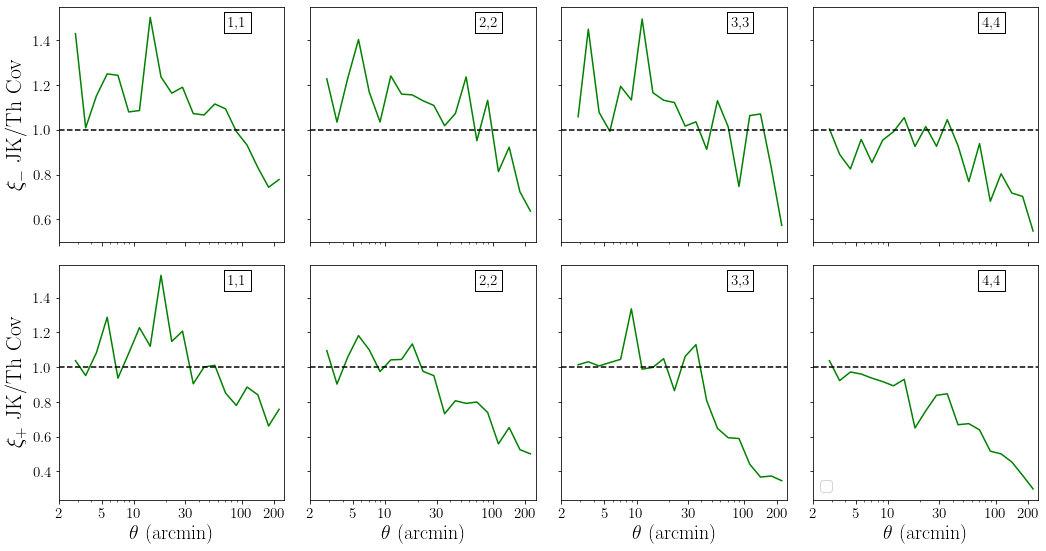

In [62]:
from astropy.io import fits
df = fits.open('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/DES_ACT.fits')
desy1 = fits.open('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/data/v0.40_fiducial.fits')

nbins = 4
bins1 = np.array([1,2,3,4])
# bins2 = np.array([4,4,4,4])
bins2 = np.array([1,2,3,4])

fig, ax = pl.subplots(2,4, figsize = (15,8),sharex=True,sharey='row')
jc = 0
texts_kk = []
for j1 in range(len(bins1)):
    texts_kk.append(str(bins1[j1]) + ',' + str(bins2[j1]))
for j1 in range(2):    
    for j2 in range(4):
        
        if j1 == 0:    
            bin1 = desy1['xim'].data['BIN1']
            bin2 = desy1['xim'].data['BIN2']
            ind_sel = np.where((bin1 == bins1[j2]) & (bin2 == bins2[j2]))[0]
            if len(ind_sel) == 0:
                ind_sel = np.where((bin1 == bins2[j2]) & (bin2 == bins1[j2]))[0]

            bin1_jk = df['xim'].data['BIN1']
            bin2_jk = df['xim'].data['BIN2']
            ind_sel_jk = np.where((bin1_jk == bins1[j2]) & (bin2_jk == bins2[j2]))[0]
            if len(ind_sel_jk) == 0:
                ind_sel_jk = np.where((bin1_jk == bins2[j2]) & (bin2_jk == bins1[j2]))[0]

            data_val = desy1['xim'].data['VALUE'][ind_sel]
            data_ang = desy1['xim'].data['ANG'][ind_sel]
            cov = desy1['COVMAT'].data[200:400,200:400][ind_sel,:][:,ind_sel]
            sig = np.sqrt(np.diag(cov))

            data_val = df['xim'].data['VALUE'][ind_sel_jk]
            yk_th_g = df['xim'].data['ANG'][ind_sel_jk]
            cov_jk = df['COVMAT'].data[200:400,200:400][ind_sel_jk,:][:,ind_sel_jk]
            yk_err = np.sqrt(np.diag(cov_jk))
            
            sig_th_interp = interpolate.interp1d(np.log(data_ang),np.log(sig),fill_value='extrapolate')
            sig_th_jkang = np.exp(sig_th_interp(np.log(yk_th_g)))
            ax[j1,j2].plot(yk_th_g, (yk_err/sig_th_jkang)**2, ls='-',marker='',color='green')
            
            
        if j1 == 1:
            bin1 = desy1['xip'].data['BIN1']
            bin2 = desy1['xip'].data['BIN2']
            ind_sel = np.where((bin1 == bins1[j2]) & (bin2 == bins2[j2]))[0]
            if len(ind_sel) == 0:
                ind_sel = np.where((bin1 == bins2[j2]) & (bin2 == bins1[j2]))[0]

            bin1_jk = df['xip'].data['BIN1']
            bin2_jk = df['xip'].data['BIN2']
            ind_sel_jk = np.where((bin1_jk == bins1[j2]) & (bin2_jk == bins2[j2]))[0]
            if len(ind_sel_jk) == 0:
                ind_sel_jk = np.where((bin1_jk == bins2[j2]) & (bin2_jk == bins1[j2]))[0]

            data_val = desy1['xip'].data['VALUE'][ind_sel]
            data_ang = desy1['xip'].data['ANG'][ind_sel]
            cov = desy1['COVMAT'].data[0:200,0:200][ind_sel,:][:,ind_sel]
            sig = np.sqrt(np.diag(cov))
        
            data_val = df['xip'].data['VALUE'][ind_sel_jk]
            yk_th_g = df['xip'].data['ANG'][ind_sel_jk]
            cov_jk = df['COVMAT'].data[0:200,0:200][ind_sel_jk,:][:,ind_sel_jk]
            yk_err = np.sqrt(np.diag(cov_jk))

            sig_th_interp = interpolate.interp1d(np.log(data_ang),np.log(sig),fill_value='extrapolate')
            sig_th_jkang = np.exp(sig_th_interp(np.log(yk_th_g)))
            ax[j1,j2].plot(yk_th_g, (yk_err/sig_th_jkang)**2, ls='-',marker='',color='green')


#         ax[j1,j2].set_ylim(0.4,1.4)
        ax[j1,j2].axhline(1.0,ls='--',color='k')    
        ax[j1,j2].set_xscale('log')
        
        if j1 == 1:
            ax[j1,j2].set_xlabel(r'$\theta$ (arcmin)', size = 20)
            ticks  = np.array([2,5,10,30,100,200])
            labels_bottom = ticks
            ax[0,j2].set_xticks(ticks)
            ax[0,j2].set_xticklabels(labels_bottom,  fontsize=15)
            ax[1,j2].set_xticks(ticks)
            ax[1,j2].set_xticklabels(labels_bottom,  fontsize=15)
            
        ax[j1,j2].tick_params(axis='both', which='minor', labelsize=15)    
        ax[j1,j2].tick_params(axis='both', which='major', labelsize=15)
        ax[j1,j2].set_xlim((2,250))
        
        ax[0,j2].text( 0.75, 0.96,texts_kk[j2], verticalalignment='top', horizontalalignment='left', transform=ax[0,j2].transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='black'))    
        ax[1,j2].text( 0.75, 0.96,texts_kk[j2], verticalalignment='top', horizontalalignment='left', transform=ax[1,j2].transAxes, fontsize=15, bbox=dict(facecolor='white', edgecolor='black'))    
        jc += 1

ax[0,0].set_ylabel(r'$\xi_{-}$ JK/Th Cov', size = 22)
ax[1,0].set_ylabel(r'$\xi_{+}$ JK/Th Cov', size = 22)
ax[1,3].legend(fontsize=15,loc='lower left')
pl.tight_layout()

# fig.savefig('xi_ygt_kk_allbins_sigma_comp.pdf')









In [73]:
from configobj import ConfigObj
import configparser


In [75]:
# sc_cut = configparser('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/y3-3x2pt-methods/cosmosis/scale_cuts/scales_1x2pt_v0.40ek_1.0.ini', unrepr=True)  

import configparser
config = configparser.ConfigParser()
config.read('scale_cut.ini')
print(config['2pt_like']['angle_range_xip_1_1'])


['/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/y3-3x2pt-methods/cosmosis/scale_cuts/scales_1x2pt_v0.40ek_1.0.ini']

In [83]:
(config['2pt_like']['angle_range_xip_1_1'])


'2.475 250.0'

In [68]:
import yaml



In [70]:
df = yaml.load('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/y3-3x2pt-methods/cosmosis/scale_cuts/scales_1x2pt_v0.40ek_1.0.ini')  



/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """Entry point for launching an IPython kernel.


In [72]:
a_yaml_file = open('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/y3-3x2pt-methods/cosmosis/scale_cuts/scales_1x2pt_v0.40ek_1.0.ini')
parsed_yaml_file = yaml.load(a_yaml_file, Loader=yaml.FullLoader)


ParserError: expected '<document start>', but found '<block mapping start>'
  in "/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/y3-3x2pt-methods/cosmosis/scale_cuts/scales_1x2pt_v0.40ek_1.0.ini", line 2, column 1